In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuration for ResNet Model
class_names = ['buildings','forest','glacier','mountain', 'sea','street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (224, 224)  # Standard ResNet input size

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ResNet Basic Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet18(num_classes=6, dropout_rate=0.5):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, dropout_rate)

def ResNet34(num_classes=6, dropout_rate=0.5):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, dropout_rate)

# Enhanced Data Loading with Augmentation
def load_data_resnet():
    datasets = ["data/train", "data/test"]
    output = []

    for dataset in datasets:
        images = []
        labels = []
        print(f"Loading {dataset}")

        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
        
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')   
        
        output.append((images, labels))

    return output

# Data preparation with augmentation
def prepare_data_resnet(train_images, train_labels, test_images, test_labels, batch_size=32):
    # Convert from (N, H, W, C) to (N, C, H, W) for PyTorch
    train_images = np.transpose(train_images, (0, 3, 1, 2))
    test_images = np.transpose(test_images, (0, 3, 1, 2))
    
    # Normalize to [0, 1]
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    
    # Convert to PyTorch tensors
    train_images = torch.FloatTensor(train_images)
    train_labels = torch.LongTensor(train_labels)
    test_images = torch.FloatTensor(test_images)
    test_labels = torch.LongTensor(test_labels)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_images, train_labels)
    test_dataset = TensorDataset(test_images, test_labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader

# Enhanced Training function with learning rate scheduling
def train_resnet_model(model, train_dataloader, test_dataloader, epochs=50, 
                      learning_rate=0.001, weight_decay=1e-4):
    model.to(device)
    
    # Optimizer with weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0
        
        for batch_images, batch_labels in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()
            total_loss += loss.item()
        
        train_accuracy = total_correct / total_samples
        train_loss = total_loss / len(train_dataloader)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_images, batch_labels in test_dataloader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                outputs = model(batch_images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        val_accuracy = val_correct / val_total
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Val Acc: {val_accuracy:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'train_accuracy': train_accuracy,
                'class_names': class_names
            }, 'best_resnet_model.pth')
            print(f'New best model saved with validation accuracy: {val_accuracy:.4f}')
    
    return train_losses, train_accuracies, val_accuracies

# Evaluation function with detailed metrics
def evaluate_resnet_model(model, test_dataloader):
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in test_dataloader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, all_predictions, all_labels

# Plot training history
def plot_training_history(train_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

print("ResNet model and training functions defined successfully!")
print("Model configurations:")
print(f"- Image size: {IMAGE_SIZE}")
print(f"- Number of classes: {nb_classes}")
print(f"- Classes: {class_names}")
print(f"- Device: {device}")

Using device: cuda
ResNet model and training functions defined successfully!
Model configurations:
- Image size: (224, 224)
- Number of classes: 6
- Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
- Device: cuda


RESNET-18 IMAGE CLASSIFICATION TRAINING
Loading data for ResNet...
Loading data/train


100%|██████████| 2382/2382 [00:00<00:00, 3786.57it/s]



Loading data/test


100%|██████████| 501/501 [00:00<00:00, 1635.44it/s]



Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (224, 224)
Number of classes: 6
Preparing data loaders...
Creating ResNet-18 model...
Total parameters: 11,179,590
Trainable parameters: 11,179,590

Training Configuration:
- Epochs: 50
- Learning Rate: 0.001
- Weight Decay: 0.0001
- Batch Size: 32
- Optimizer: Adam
- LR Scheduler: StepLR (step_size=15, gamma=0.1)
- Dropout Rate: 0.5

Starting training...
Creating ResNet-18 model...
Total parameters: 11,179,590
Trainable parameters: 11,179,590

Training Configuration:
- Epochs: 50
- Learning Rate: 0.001
- Weight Decay: 0.0001
- Batch Size: 32
- Optimizer: Adam
- LR Scheduler: StepLR (step_size=15, gamma=0.1)
- Dropout Rate: 0.5

Starting training...


Epoch 1/50: 100%|██████████| 439/439 [00:28<00:00, 15.18it/s]



Epoch [1/50]
Train Loss: 1.0376, Train Acc: 0.5905
Val Acc: 0.6570, LR: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 0.6570


Epoch 2/50: 100%|██████████| 439/439 [00:26<00:00, 16.65it/s]



Epoch [2/50]
Train Loss: 0.7310, Train Acc: 0.7294
Val Acc: 0.5850, LR: 0.001000
--------------------------------------------------


Epoch 3/50: 100%|██████████| 439/439 [00:26<00:00, 16.63it/s]



Epoch [3/50]
Train Loss: 0.6365, Train Acc: 0.7656
Val Acc: 0.7553, LR: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 0.7553


Epoch 4/50: 100%|██████████| 439/439 [00:26<00:00, 16.69it/s]



Epoch [4/50]
Train Loss: 0.5691, Train Acc: 0.7956
Val Acc: 0.6890, LR: 0.001000
--------------------------------------------------


Epoch 5/50: 100%|██████████| 439/439 [00:26<00:00, 16.68it/s]



Epoch [5/50]
Train Loss: 0.5405, Train Acc: 0.8038
Val Acc: 0.7757, LR: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 0.7757


Epoch 6/50: 100%|██████████| 439/439 [00:26<00:00, 16.65it/s]



Epoch [6/50]
Train Loss: 0.4981, Train Acc: 0.8245
Val Acc: 0.7257, LR: 0.001000
--------------------------------------------------


Epoch 7/50: 100%|██████████| 439/439 [00:26<00:00, 16.65it/s]



Epoch [7/50]
Train Loss: 0.4687, Train Acc: 0.8351
Val Acc: 0.5777, LR: 0.001000
--------------------------------------------------


Epoch 8/50: 100%|██████████| 439/439 [00:26<00:00, 16.65it/s]



Epoch [8/50]
Train Loss: 0.4607, Train Acc: 0.8392
Val Acc: 0.7173, LR: 0.001000
--------------------------------------------------


Epoch 9/50: 100%|██████████| 439/439 [00:26<00:00, 16.70it/s]



Epoch [9/50]
Train Loss: 0.4366, Train Acc: 0.8436
Val Acc: 0.8193, LR: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 0.8193


Epoch 10/50: 100%|██████████| 439/439 [00:26<00:00, 16.65it/s]



Epoch [10/50]
Train Loss: 0.4044, Train Acc: 0.8571
Val Acc: 0.8053, LR: 0.001000
--------------------------------------------------


Epoch 11/50: 100%|██████████| 439/439 [00:26<00:00, 16.58it/s]



Epoch [11/50]
Train Loss: 0.3930, Train Acc: 0.8620
Val Acc: 0.7693, LR: 0.001000
--------------------------------------------------


Epoch 12/50: 100%|██████████| 439/439 [00:26<00:00, 16.56it/s]



Epoch [12/50]
Train Loss: 0.3641, Train Acc: 0.8701
Val Acc: 0.7807, LR: 0.001000
--------------------------------------------------


Epoch 13/50: 100%|██████████| 439/439 [00:26<00:00, 16.57it/s]



Epoch [13/50]
Train Loss: 0.3549, Train Acc: 0.8761
Val Acc: 0.8623, LR: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 0.8623


Epoch 14/50: 100%|██████████| 439/439 [00:26<00:00, 16.53it/s]



Epoch [14/50]
Train Loss: 0.3445, Train Acc: 0.8813
Val Acc: 0.7850, LR: 0.001000
--------------------------------------------------


Epoch 15/50: 100%|██████████| 439/439 [00:27<00:00, 16.01it/s]



Epoch [15/50]
Train Loss: 0.3413, Train Acc: 0.8801
Val Acc: 0.8407, LR: 0.000100
--------------------------------------------------


Epoch 16/50: 100%|██████████| 439/439 [00:27<00:00, 15.93it/s]



Epoch [16/50]
Train Loss: 0.2300, Train Acc: 0.9230
Val Acc: 0.8980, LR: 0.000100
--------------------------------------------------
New best model saved with validation accuracy: 0.8980


Epoch 17/50: 100%|██████████| 439/439 [00:27<00:00, 15.82it/s]



Epoch [17/50]
Train Loss: 0.1963, Train Acc: 0.9340
Val Acc: 0.9010, LR: 0.000100
--------------------------------------------------
New best model saved with validation accuracy: 0.9010


Epoch 18/50: 100%|██████████| 439/439 [00:27<00:00, 15.84it/s]



Epoch [18/50]
Train Loss: 0.1735, Train Acc: 0.9434
Val Acc: 0.8910, LR: 0.000100
--------------------------------------------------


Epoch 19/50: 100%|██████████| 439/439 [00:27<00:00, 15.91it/s]



Epoch [19/50]
Train Loss: 0.1550, Train Acc: 0.9476
Val Acc: 0.8940, LR: 0.000100
--------------------------------------------------


Epoch 20/50: 100%|██████████| 439/439 [00:27<00:00, 16.07it/s]



Epoch [20/50]
Train Loss: 0.1359, Train Acc: 0.9551
Val Acc: 0.8910, LR: 0.000100
--------------------------------------------------


Epoch 21/50: 100%|██████████| 439/439 [00:27<00:00, 15.91it/s]



Epoch [21/50]
Train Loss: 0.1159, Train Acc: 0.9631
Val Acc: 0.8923, LR: 0.000100
--------------------------------------------------


Epoch 22/50: 100%|██████████| 439/439 [00:27<00:00, 15.74it/s]



Epoch [22/50]
Train Loss: 0.1003, Train Acc: 0.9684
Val Acc: 0.8917, LR: 0.000100
--------------------------------------------------


Epoch 23/50: 100%|██████████| 439/439 [00:27<00:00, 15.93it/s]



Epoch [23/50]
Train Loss: 0.0832, Train Acc: 0.9747
Val Acc: 0.8897, LR: 0.000100
--------------------------------------------------


Epoch 24/50: 100%|██████████| 439/439 [00:27<00:00, 15.84it/s]



Epoch [24/50]
Train Loss: 0.0662, Train Acc: 0.9803
Val Acc: 0.8830, LR: 0.000100
--------------------------------------------------


Epoch 25/50: 100%|██████████| 439/439 [00:27<00:00, 15.77it/s]



Epoch [25/50]
Train Loss: 0.0581, Train Acc: 0.9845
Val Acc: 0.8860, LR: 0.000100
--------------------------------------------------


Epoch 26/50: 100%|██████████| 439/439 [00:27<00:00, 15.83it/s]



Epoch [26/50]
Train Loss: 0.0478, Train Acc: 0.9857
Val Acc: 0.8833, LR: 0.000100
--------------------------------------------------


Epoch 27/50: 100%|██████████| 439/439 [00:27<00:00, 15.84it/s]



Epoch [27/50]
Train Loss: 0.0384, Train Acc: 0.9897
Val Acc: 0.8777, LR: 0.000100
--------------------------------------------------


Epoch 28/50: 100%|██████████| 439/439 [00:27<00:00, 16.08it/s]



Epoch [28/50]
Train Loss: 0.0374, Train Acc: 0.9893
Val Acc: 0.8860, LR: 0.000100
--------------------------------------------------


Epoch 29/50: 100%|██████████| 439/439 [00:27<00:00, 16.03it/s]



Epoch [29/50]
Train Loss: 0.0281, Train Acc: 0.9927
Val Acc: 0.8900, LR: 0.000100
--------------------------------------------------


Epoch 30/50: 100%|██████████| 439/439 [00:27<00:00, 16.14it/s]



Epoch [30/50]
Train Loss: 0.0280, Train Acc: 0.9927
Val Acc: 0.8910, LR: 0.000010
--------------------------------------------------


Epoch 31/50: 100%|██████████| 439/439 [00:27<00:00, 16.09it/s]



Epoch [31/50]
Train Loss: 0.0184, Train Acc: 0.9969
Val Acc: 0.8897, LR: 0.000010
--------------------------------------------------


Epoch 32/50: 100%|██████████| 439/439 [00:27<00:00, 16.07it/s]



Epoch [32/50]
Train Loss: 0.0166, Train Acc: 0.9961
Val Acc: 0.8860, LR: 0.000010
--------------------------------------------------


Epoch 33/50: 100%|██████████| 439/439 [00:27<00:00, 16.18it/s]



Epoch [33/50]
Train Loss: 0.0136, Train Acc: 0.9979
Val Acc: 0.8883, LR: 0.000010
--------------------------------------------------


Epoch 34/50: 100%|██████████| 439/439 [00:27<00:00, 16.17it/s]



Epoch [34/50]
Train Loss: 0.0133, Train Acc: 0.9979
Val Acc: 0.8880, LR: 0.000010
--------------------------------------------------


Epoch 35/50: 100%|██████████| 439/439 [00:27<00:00, 16.11it/s]



Epoch [35/50]
Train Loss: 0.0114, Train Acc: 0.9981
Val Acc: 0.8860, LR: 0.000010
--------------------------------------------------


Epoch 36/50: 100%|██████████| 439/439 [00:27<00:00, 16.14it/s]



Epoch [36/50]
Train Loss: 0.0117, Train Acc: 0.9981
Val Acc: 0.8830, LR: 0.000010
--------------------------------------------------


Epoch 37/50: 100%|██████████| 439/439 [00:27<00:00, 16.16it/s]



Epoch [37/50]
Train Loss: 0.0109, Train Acc: 0.9974
Val Acc: 0.8843, LR: 0.000010
--------------------------------------------------


Epoch 38/50: 100%|██████████| 439/439 [00:27<00:00, 16.19it/s]



Epoch [38/50]
Train Loss: 0.0102, Train Acc: 0.9983
Val Acc: 0.8853, LR: 0.000010
--------------------------------------------------


Epoch 39/50: 100%|██████████| 439/439 [00:27<00:00, 16.24it/s]



Epoch [39/50]
Train Loss: 0.0105, Train Acc: 0.9983
Val Acc: 0.8857, LR: 0.000010
--------------------------------------------------


Epoch 40/50: 100%|██████████| 439/439 [00:27<00:00, 16.16it/s]



Epoch [40/50]
Train Loss: 0.0099, Train Acc: 0.9984
Val Acc: 0.8857, LR: 0.000010
--------------------------------------------------


Epoch 41/50: 100%|██████████| 439/439 [00:27<00:00, 16.25it/s]



Epoch [41/50]
Train Loss: 0.0101, Train Acc: 0.9977
Val Acc: 0.8843, LR: 0.000010
--------------------------------------------------


Epoch 42/50: 100%|██████████| 439/439 [00:26<00:00, 16.29it/s]



Epoch [42/50]
Train Loss: 0.0097, Train Acc: 0.9981
Val Acc: 0.8850, LR: 0.000010
--------------------------------------------------


Epoch 43/50: 100%|██████████| 439/439 [00:27<00:00, 16.16it/s]



Epoch [43/50]
Train Loss: 0.0107, Train Acc: 0.9979
Val Acc: 0.8847, LR: 0.000010
--------------------------------------------------


Epoch 44/50: 100%|██████████| 439/439 [00:27<00:00, 16.12it/s]



Epoch [44/50]
Train Loss: 0.0085, Train Acc: 0.9983
Val Acc: 0.8860, LR: 0.000010
--------------------------------------------------


Epoch 45/50: 100%|██████████| 439/439 [00:27<00:00, 16.08it/s]



Epoch [45/50]
Train Loss: 0.0097, Train Acc: 0.9978
Val Acc: 0.8860, LR: 0.000001
--------------------------------------------------


Epoch 46/50: 100%|██████████| 439/439 [00:27<00:00, 16.11it/s]



Epoch [46/50]
Train Loss: 0.0087, Train Acc: 0.9984
Val Acc: 0.8867, LR: 0.000001
--------------------------------------------------


Epoch 47/50: 100%|██████████| 439/439 [00:27<00:00, 16.07it/s]



Epoch [47/50]
Train Loss: 0.0080, Train Acc: 0.9987
Val Acc: 0.8880, LR: 0.000001
--------------------------------------------------


Epoch 48/50: 100%|██████████| 439/439 [00:27<00:00, 16.02it/s]



Epoch [48/50]
Train Loss: 0.0072, Train Acc: 0.9989
Val Acc: 0.8847, LR: 0.000001
--------------------------------------------------


Epoch 49/50: 100%|██████████| 439/439 [00:27<00:00, 16.05it/s]



Epoch [49/50]
Train Loss: 0.0087, Train Acc: 0.9984
Val Acc: 0.8857, LR: 0.000001
--------------------------------------------------


Epoch 50/50: 100%|██████████| 439/439 [00:27<00:00, 16.12it/s]



Epoch [50/50]
Train Loss: 0.0089, Train Acc: 0.9979
Val Acc: 0.8857, LR: 0.000001
--------------------------------------------------
Plotting training history...


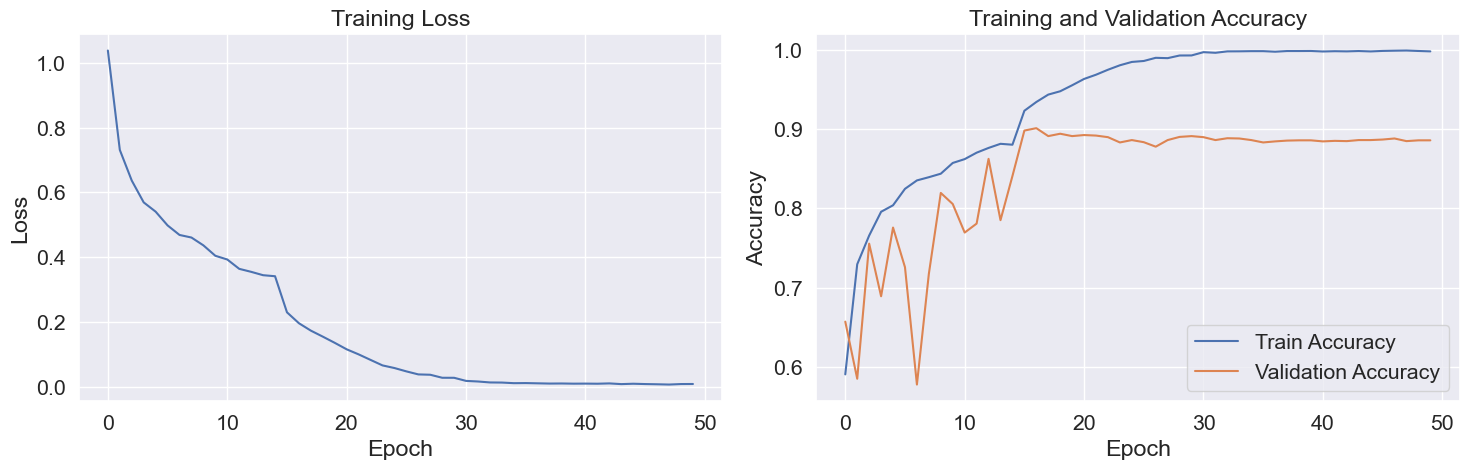

Loading best model for final evaluation...
Evaluating model on test set...

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.86      0.89       437
      forest       0.98      0.98      0.98       474
     glacier       0.90      0.81      0.85       553
    mountain       0.81      0.91      0.86       525
         sea       0.92      0.92      0.92       510
      street       0.90      0.93      0.92       501

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000


Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.86      0.89       437
      forest       0.98      0.98      0.98       474
     glacier       0.90      0.81      0.85       553
    mountain       0.81      0.91      0.86       525
         sea       0.92      0.92      0.92       510
      str

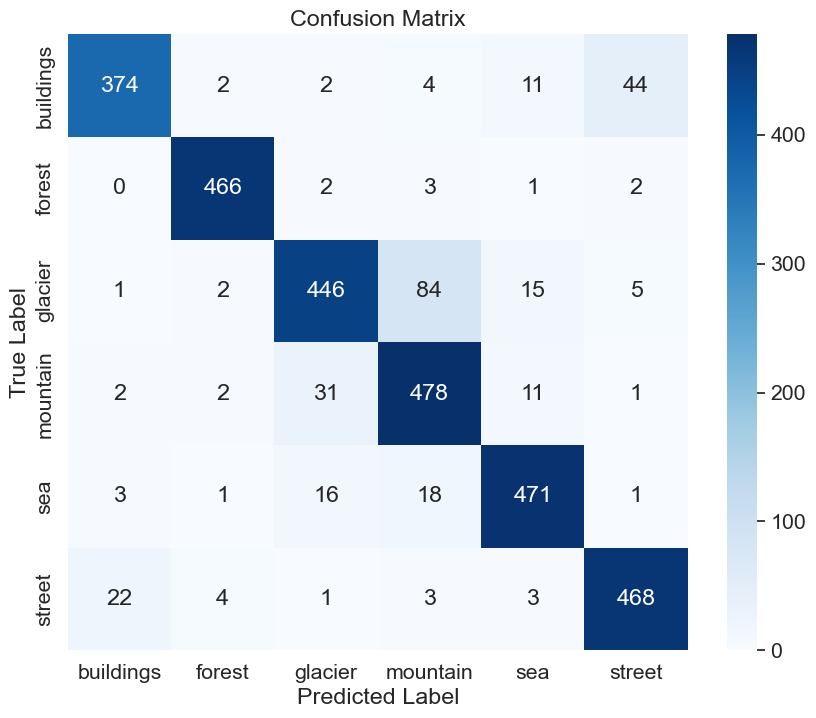


Final Results:
- Best Validation Accuracy: 0.9010
- Final Test Accuracy: 0.9010

Model saved as 'best_resnet_model.pth'
Training completed successfully!


In [25]:
# Main execution for ResNet Training
if __name__ == "__main__":
    print("="*60)
    print("RESNET-18 IMAGE CLASSIFICATION TRAINING")
    print("="*60)
    
    # Load and prepare data
    print("Loading data for ResNet...")
    (train_images, train_labels), (test_images, test_labels) = load_data_resnet()
    
    # Shuffle training data
    train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
    
    n_train = train_labels.shape[0]
    n_test = test_labels.shape[0]
    
    print(f"Number of training examples: {n_train}")
    print(f"Number of testing examples: {n_test}")
    print(f"Each image is of size: {IMAGE_SIZE}")
    print(f"Number of classes: {nb_classes}")
    
    # Prepare dataloaders
    print("Preparing data loaders...")
    train_dataloader, test_dataloader = prepare_data_resnet(
        train_images, train_labels, test_images, test_labels, batch_size=32
    )
    
    # Create ResNet-18 model
    print("Creating ResNet-18 model...")
    model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training hyperparameters
    EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    
    print(f"\nTraining Configuration:")
    print(f"- Epochs: {EPOCHS}")
    print(f"- Learning Rate: {LEARNING_RATE}")
    print(f"- Weight Decay: {WEIGHT_DECAY}")
    print(f"- Batch Size: 32")
    print(f"- Optimizer: Adam")
    print(f"- LR Scheduler: StepLR (step_size=15, gamma=0.1)")
    print(f"- Dropout Rate: 0.5")
    
    # Train the model
    print("\nStarting training...")
    train_losses, train_accuracies, val_accuracies = train_resnet_model(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    # Plot training history
    print("Plotting training history...")
    plot_training_history(train_losses, train_accuracies, val_accuracies)
    
    # Load best model and evaluate
    print("Loading best model for final evaluation...")
    checkpoint = torch.load('best_resnet_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print("Evaluating model on test set...")
    test_accuracy, predictions, true_labels = evaluate_resnet_model(model, test_dataloader)
    
    print(f"\nFinal Results:")
    print(f"- Best Validation Accuracy: {checkpoint['val_accuracy']:.4f}")
    print(f"- Final Test Accuracy: {test_accuracy:.4f}")
    
    print("\nModel saved as 'best_resnet_model.pth'")
    print("Training completed successfully!")

In [26]:
# Image Prediction Functions
import os
import random
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess a single image for prediction
    """
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        image = cv2.resize(image, target_size)
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Convert from (H, W, C) to (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        
        # Add batch dimension (1, C, H, W)
        image = np.expand_dims(image, axis=0)
        
        # Convert to tensor
        image_tensor = torch.FloatTensor(image)
        
        return image_tensor
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_single_image(model, image_path, class_names, device):
    """
    Predict the class of a single image
    """
    # Preprocess image
    image_tensor = load_and_preprocess_image(image_path)
    
    if image_tensor is None:
        return None, None, None
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Get predictions
        outputs = model(image_tensor)
        
        # Get probabilities using softmax
        probabilities = F.softmax(outputs, dim=1)
        
        # Get predicted class
        _, predicted_idx = torch.max(outputs, 1)
        predicted_idx = predicted_idx.item()
        
        # Get confidence score
        confidence = probabilities[0][predicted_idx].item()
        
        # Get predicted class name
        predicted_class = class_names[predicted_idx]
        
        return predicted_class, confidence, probabilities[0].cpu().numpy()

def predict_multiple_images(model, image_paths, class_names, device):
    """
    Predict classes for multiple images
    """
    results = []
    
    for image_path in image_paths:
        print(f"Predicting: {os.path.basename(image_path)}")
        
        predicted_class, confidence, probabilities = predict_single_image(
            model, image_path, class_names, device
        )
        
        if predicted_class is not None:
            results.append({
                'image_path': image_path,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': probabilities
            })
            
            print(f"  Predicted: {predicted_class} (Confidence: {confidence:.4f})")
        else:
            print(f"  Failed to predict")
        
        print("-" * 40)
    
    return results

def visualize_predictions(results, class_names, num_images=6):
    """
    Visualize prediction results with images and probability bars
    """
    if not results:
        print("No results to visualize")
        return
    
    # Limit number of images to display
    results = results[:num_images]
    
    # Calculate grid size
    cols = 3
    rows = (len(results) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows * 2, cols, figsize=(15, rows * 6))
    
    if rows == 1:
        axes = axes.reshape(2, cols)
    
    for idx, result in enumerate(results):
        col = idx % cols
        row_img = (idx // cols) * 2
        row_prob = row_img + 1
        
        # Load and display image
        image = cv2.imread(result['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        axes[row_img, col].imshow(image)
        axes[row_img, col].set_title(
            f"Predicted: {result['predicted_class']}\n"
            f"Confidence: {result['confidence']:.3f}",
            fontsize=12
        )
        axes[row_img, col].axis('off')
        
        # Display probability distribution
        probabilities = result['probabilities']
        colors = ['red' if i == class_names.index(result['predicted_class']) else 'blue' 
                 for i in range(len(class_names))]
        
        bars = axes[row_prob, col].bar(class_names, probabilities, color=colors, alpha=0.7)
        axes[row_prob, col].set_title('Class Probabilities', fontsize=10)
        axes[row_prob, col].set_ylabel('Probability')
        axes[row_prob, col].set_ylim(0, 1)
        axes[row_prob, col].tick_params(axis='x', rotation=45)
        
        # Add probability values on bars
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            axes[row_prob, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                   f'{prob:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Hide empty subplots
    total_subplots = rows * cols
    for idx in range(len(results), total_subplots):
        col = idx % cols
        row_img = (idx // cols) * 2
        row_prob = row_img + 1
        axes[row_img, col].axis('off')
        axes[row_prob, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def get_random_test_images(test_data_dir, num_images=6):
    """
    Get random images from test directory for prediction
    """
    image_paths = []
    
    # Collect all image paths
    for class_folder in os.listdir(test_data_dir):
        class_path = os.path.join(test_data_dir, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, image_file))
    
    # Randomly select images
    if len(image_paths) >= num_images:
        selected_images = random.sample(image_paths, num_images)
    else:
        selected_images = image_paths
    
    return selected_images

print("Image prediction functions defined successfully!")
print("Available functions:")
print("- predict_single_image(): Predict one image")
print("- predict_multiple_images(): Predict multiple images")
print("- visualize_predictions(): Show results with images and probabilities")
print("- get_random_test_images(): Get random test images for prediction")

Image prediction functions defined successfully!
Available functions:
- predict_single_image(): Predict one image
- predict_multiple_images(): Predict multiple images
- visualize_predictions(): Show results with images and probabilities
- get_random_test_images(): Get random test images for prediction


IMAGE PREDICTION WITH TRAINED RESNET MODEL
Loading trained ResNet model...
✅ Model loaded successfully!
Model validation accuracy: 0.9010
Model was trained for epoch: 17

METHOD 1: PREDICTING RANDOM TEST IMAGES
Selected 6 random test images for prediction:
  - data/test\glacier\22258.jpg
  - data/test\street\20069.jpg
  - data/test\glacier\22264.jpg
  - data/test\sea\22930.jpg
  - data/test\mountain\21236.jpg
  - data/test\glacier\23608.jpg

Making predictions...
Predicting: 22258.jpg
  Predicted: glacier (Confidence: 0.7013)
----------------------------------------
Predicting: 20069.jpg
  Predicted: street (Confidence: 0.9162)
----------------------------------------
Predicting: 22264.jpg
  Predicted: glacier (Confidence: 0.7567)
----------------------------------------
Predicting: 22930.jpg
  Predicted: sea (Confidence: 0.9896)
----------------------------------------
Predicting: 21236.jpg
  Predicted: mountain (Confidence: 0.9946)
----------------------------------------
Predicting:

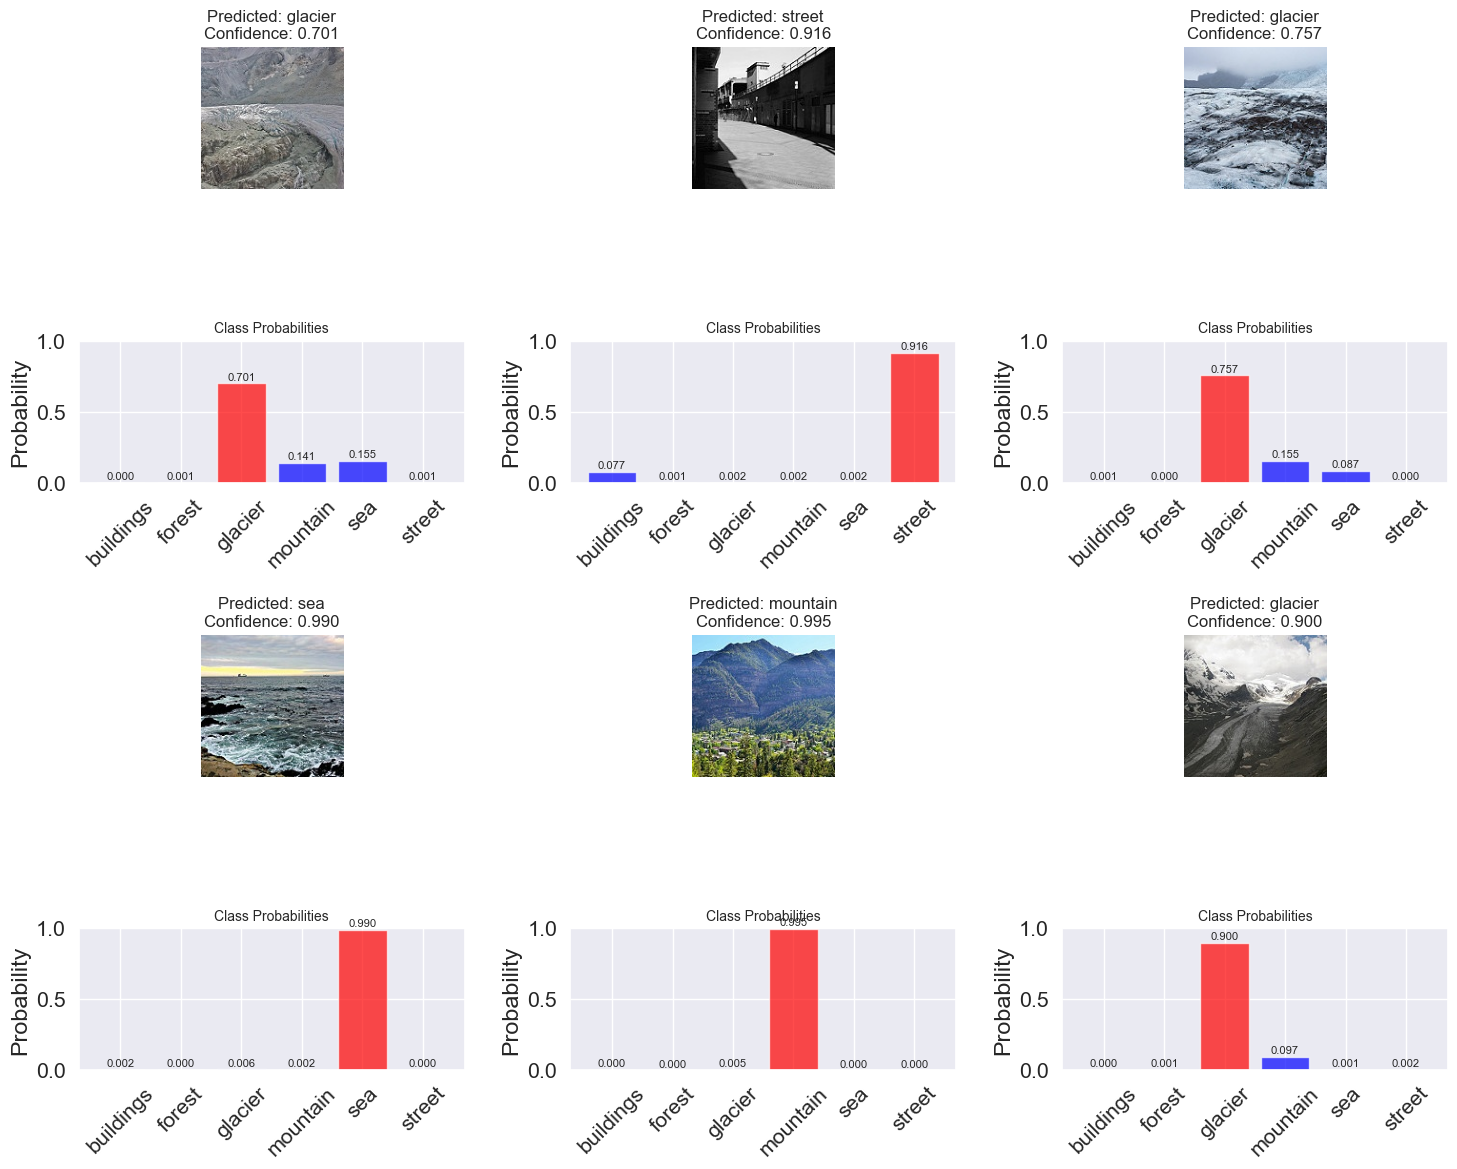


METHOD 2: PREDICTING IMAGES FROM PRED FOLDER
Found 6 images in pred folder:
  - 10004.jpg
  - 10005.jpg
  - 10012.jpg
  - 10013.jpg
  - 10017.jpg
  - 10021.jpg

Making predictions on pred images...
Predicting: 10004.jpg
  Predicted: buildings (Confidence: 0.9006)
----------------------------------------
Predicting: 10005.jpg
  Predicted: mountain (Confidence: 0.9315)
----------------------------------------
Predicting: 10012.jpg
  Predicted: street (Confidence: 0.9978)
----------------------------------------
Predicting: 10013.jpg
  Predicted: mountain (Confidence: 0.9852)
----------------------------------------
Predicting: 10017.jpg
  Predicted: mountain (Confidence: 0.8740)
----------------------------------------
Predicting: 10021.jpg
  Predicted: forest (Confidence: 0.9998)
----------------------------------------

Visualizing pred folder results...


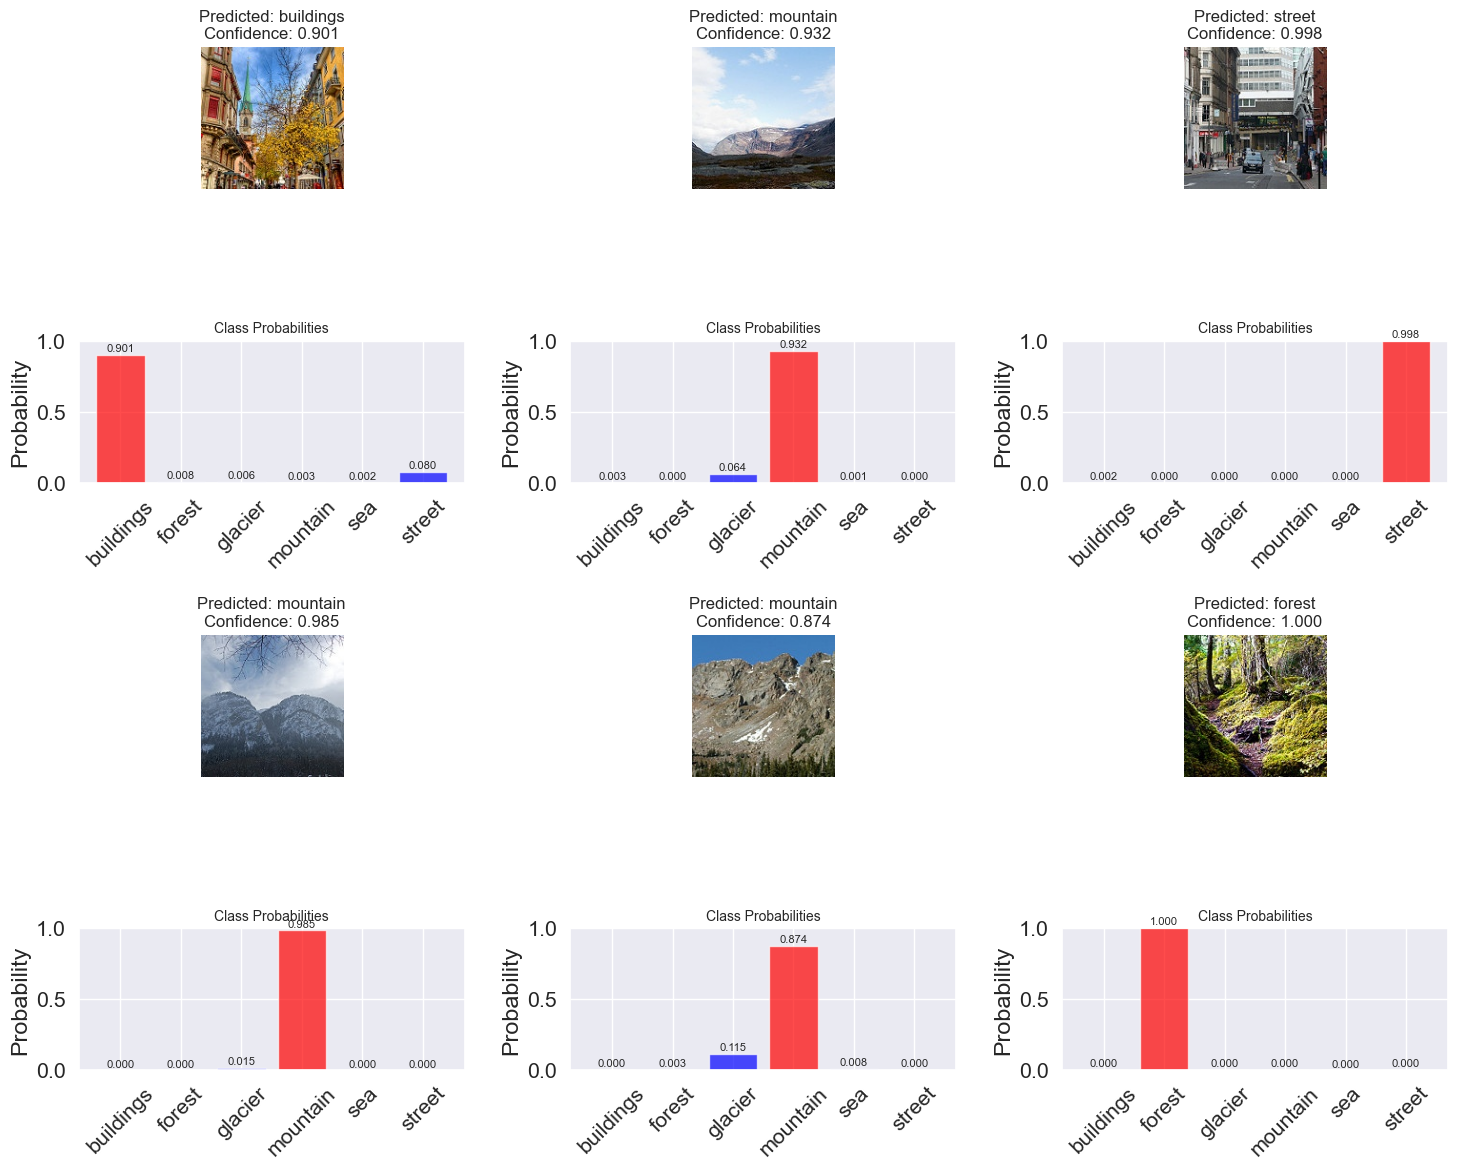


METHOD 3: SINGLE IMAGE PREDICTION EXAMPLE
Predicting single image: data/test\buildings\20057.jpg

🎯 Prediction Results:
   Image: 20057.jpg
   Predicted Class: buildings
   Confidence: 0.9999
   True Class: buildings

📊 All Class Probabilities:
   buildings: 0.9999
   forest: 0.0000
   glacier: 0.0000
   mountain: 0.0000
   sea: 0.0000
   street: 0.0000

PREDICTION COMPLETED!


In [27]:
# Load Trained Model and Make Predictions
print("="*60)
print("IMAGE PREDICTION WITH TRAINED RESNET MODEL")
print("="*60)

# Load the best trained model
try:
    print("Loading trained ResNet model...")
    checkpoint = torch.load('best_resnet_model.pth', map_location=device)
    
    # Create model with same architecture
    loaded_model = ResNet18(num_classes=nb_classes, dropout_rate=0.5)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    loaded_model.eval()
    
    print("✅ Model loaded successfully!")
    print(f"Model validation accuracy: {checkpoint['val_accuracy']:.4f}")
    print(f"Model was trained for epoch: {checkpoint['epoch'] + 1}")
    
except FileNotFoundError:
    print("❌ Model file 'best_resnet_model.pth' not found!")
    print("Please train the model first by running the training cells above.")
    loaded_model = None

if loaded_model is not None:
    # Method 1: Predict on random test images
    print("\n" + "="*50)
    print("METHOD 1: PREDICTING RANDOM TEST IMAGES")
    print("="*50)
    
    try:
        # Get random test images
        test_data_dir = "data/test"
        random_images = get_random_test_images(test_data_dir, num_images=6)
        
        if random_images:
            print(f"Selected {len(random_images)} random test images for prediction:")
            for img_path in random_images:
                print(f"  - {img_path}")
            
            # Make predictions
            print("\nMaking predictions...")
            prediction_results = predict_multiple_images(
                loaded_model, random_images, class_names, device
            )
            
            # Visualize results
            print("\nVisualizing prediction results...")
            visualize_predictions(prediction_results, class_names)
            
        else:
            print("❌ No test images found in 'data/test' directory")
            
    except Exception as e:
        print(f"❌ Error during random image prediction: {str(e)}")
    
    # Method 2: Predict specific images from pred folder
    print("\n" + "="*50)
    print("METHOD 2: PREDICTING IMAGES FROM PRED FOLDER")
    print("="*50)
    
    try:
        pred_data_dir = "data/pred"
        if os.path.exists(pred_data_dir):
            # Get first 6 images from pred folder
            pred_images = []
            for file in os.listdir(pred_data_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    pred_images.append(os.path.join(pred_data_dir, file))
                if len(pred_images) >= 6:  # Limit to 6 images
                    break
            
            if pred_images:
                print(f"Found {len(pred_images)} images in pred folder:")
                for img_path in pred_images:
                    print(f"  - {os.path.basename(img_path)}")
                
                # Make predictions
                print("\nMaking predictions on pred images...")
                pred_results = predict_multiple_images(
                    loaded_model, pred_images, class_names, device
                )
                
                # Visualize results
                print("\nVisualizing pred folder results...")
                visualize_predictions(pred_results, class_names)
                
            else:
                print("❌ No images found in 'data/pred' directory")
        else:
            print("❌ 'data/pred' directory not found")
            
    except Exception as e:
        print(f"❌ Error during pred folder prediction: {str(e)}")
    
    # Method 3: Single image prediction example
    print("\n" + "="*50)
    print("METHOD 3: SINGLE IMAGE PREDICTION EXAMPLE")
    print("="*50)
    
    try:
        # Try to predict a single image
        single_image_path = None
        
        # Look for any image in test directory
        for class_folder in os.listdir("data/test"):
            class_path = os.path.join("data/test", class_folder)
            if os.path.isdir(class_path):
                for image_file in os.listdir(class_path):
                    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        single_image_path = os.path.join(class_path, image_file)
                        break
                if single_image_path:
                    break
        
        if single_image_path:
            print(f"Predicting single image: {single_image_path}")
            
            predicted_class, confidence, probabilities = predict_single_image(
                loaded_model, single_image_path, class_names, device
            )
            
            if predicted_class:
                print(f"\n🎯 Prediction Results:")
                print(f"   Image: {os.path.basename(single_image_path)}")
                print(f"   Predicted Class: {predicted_class}")
                print(f"   Confidence: {confidence:.4f}")
                print(f"   True Class: {os.path.basename(os.path.dirname(single_image_path))}")
                
                print(f"\n📊 All Class Probabilities:")
                for i, (class_name, prob) in enumerate(zip(class_names, probabilities)):
                    print(f"   {class_name}: {prob:.4f}")
            else:
                print("❌ Failed to predict single image")
        else:
            print("❌ No test images found for single prediction")
            
    except Exception as e:
        print(f"❌ Error during single image prediction: {str(e)}")

print("\n" + "="*60)
print("PREDICTION COMPLETED!")
print("="*60)